# Five Cells(aka: Faibuseruzu)

The goal is to divide the grid into regions of exactly Five cells. The number inside a cell represents how many of its Five sides are segments of region borders (including the border of the grid).

<https://www.cross-plus-a.com/html/cros7fzu.htm>



In [43]:

import numpy as np
from ortools.sat.python import cp_model as cp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import MultipleLocator
import random

COLORS = {
    "F" : "#8CD4C7",
    "I" : "#FFFFB4",
    "L" : "#BFBADA",
    "N" : "#BD7FBD",
    "P" : "#D9D9D9",
    "T" : "#FCB561",
    "U" : "#B3DE68",
    "V" : "#FCCCE5",
    "W" : "#FA7F73",
    "X" : "#7EB0D4",
    "Y" : "#CCEBC4",
    "Z" : "#FFED70"
}

In [44]:
def readGrid(path):
    with open(f"../assets/data/fivecells/{path}.txt") as f:
        num = f.readline()
        m, n = num.split(" ")[0], num.split(" ")[1]
        grid = f.readlines()
        res = [g.strip().split(" ") for g in grid]
        return int(m), int(n), res

In [59]:
def gen_patterns():
    init_name = "FILNPTUVWXYZ"
    init_Patterns = [
        np.array([
            [0,1,1],
            [1,1,0],
            [0,1,0]
        ]),
        np.array([
            [1],
            [1],
            [1],
            [1],
            [1]
        ]),
        np.array([
            [1,0],
            [1,0],
            [1,0],
            [1,1]
        ]),
        np.array([
            [0,1],
            [1,1],
            [1,0],
            [1,0],
        ]),
        np.array([
            [1,1],
            [1,1],
            [1,0]
        ]),
        np.array([
            [1,1,1],
            [0,1,0],
            [0,1,0]
        ]),
        np.array([
            [1,0,1],
            [1,1,1]
        ]),
        np.array([
            [1,0,0],
            [1,0,0],
            [1,1,1] 
        ]),
        np.array([
            [1,0,0],
            [1,1,0],
            [0,1,1] 
        ]),
        np.array([
            [0,1,0],
            [1,1,1],
            [0,1,0] 
        ]),
        np.array([
            [0,1],
            [1,1],
            [0,1],
            [0,1],
        ]),
        np.array([
            [1,1,0],
            [0,1,0],
            [0,1,1]
        ])
    ]
    init_border = [
        np.array([
            [0,2,3],
            [3,1,0],
            [0,3,0]
        ]),
        np.array([
            [3],
            [2],
            [2],
            [2],
            [3]
        ]),
        np.array([
            [3,0],
            [2,0],
            [2,0],
            [2,3]
        ]),
        np.array([
            [0,3],
            [2,2],
            [2,0],
            [3,0],
        ]),
        np.array([
            [2,2],
            [1,2],
            [3,0]
        ]),
        np.array([
            [3,1,3],
            [0,2,0],
            [0,3,0]
        ]),
        np.array([
            [3,0,3],
            [2,2,2]
        ]),
        np.array([
            [3,0,0],
            [2,0,0],
            [2,2,3] 
        ]),
        np.array([
            [3,0,0],
            [2,2,0],
            [0,2,3] 
        ]),
        np.array([
            [0,3,0],
            [3,0,3],
            [0,3,0] 
        ]),
        np.array([
            [0,3],
            [3,1],
            [0,2],
            [0,3],
        ]),
        np.array([
            [3,2,0],
            [0,2,0],
            [0,2,3]
        ])
    ]
    all_patterns = []
    pattern_index = []
    all_pattern_temp = []
    for pidx , pattern in enumerate(init_Patterns):
        cnt_idx = 0
        border_pattern = init_border[pidx]
        for i in range(1,5):
            pattern_rot = np.rot90(pattern,  k = i, axes = (0,1))
            pattern_flip = np.fliplr(pattern_rot)
            
            border_rot = np.rot90(border_pattern, k = i, axes = (0,1))
            border_flip = np.fliplr(border_rot)
            
            pattern_rot_flag = True 
            pattern_flip_flag = True
            for compare_pattern in all_pattern_temp:
                if pattern_rot_flag and np.array_equal(pattern_rot, compare_pattern):
                    pattern_rot_flag = False 
                if pattern_flip_flag and np.array_equal(pattern_flip, compare_pattern):
                    pattern_flip_flag = False
                if not pattern_rot_flag and not pattern_flip_flag:
                    break
                
            if pattern_rot_flag:
                cnt_idx += 1
                all_patterns.append([pattern_rot, border_rot])
                all_pattern_temp.append(pattern_rot)
                pattern_index.append(f"{init_name[pidx]}_{cnt_idx}")
            if pattern_flip_flag and not np.array_equal(pattern_rot, pattern_flip):
                cnt_idx += 1
                all_patterns.append([pattern_flip, border_flip])
                all_pattern_temp.append(pattern_flip)
                pattern_index.append(f"{init_name[pidx]}_{cnt_idx}")

    res_all_patterns = dict(zip(pattern_index, all_patterns))
    print(f"# of Pentomino in Total: {len(all_patterns)}")
    return res_all_patterns

if __name__ == "__main__":
    res = gen_patterns()
    # for k, v in res.items():
    #     print(k, v)


# of Pentomino in Total: 63


# of Pentomino in Total: 63
Start Solving...(Please wait...)
总的摆放数： 1 （没有消重）

CpSolverResponse summary:
status: OPTIMAL
objective: 0
best_bound: 0
integers: 25
booleans: 10708
conflicts: 0
branches: 0
propagations: 10708
integer_propagations: 13
restarts: 0
lp_iterations: 0
walltime: 0.122419
usertime: 0.122419
deterministic_time: 0.14242
gap_integral: 0
solution_fingerprint: 0xcf1aa7c790173a8b



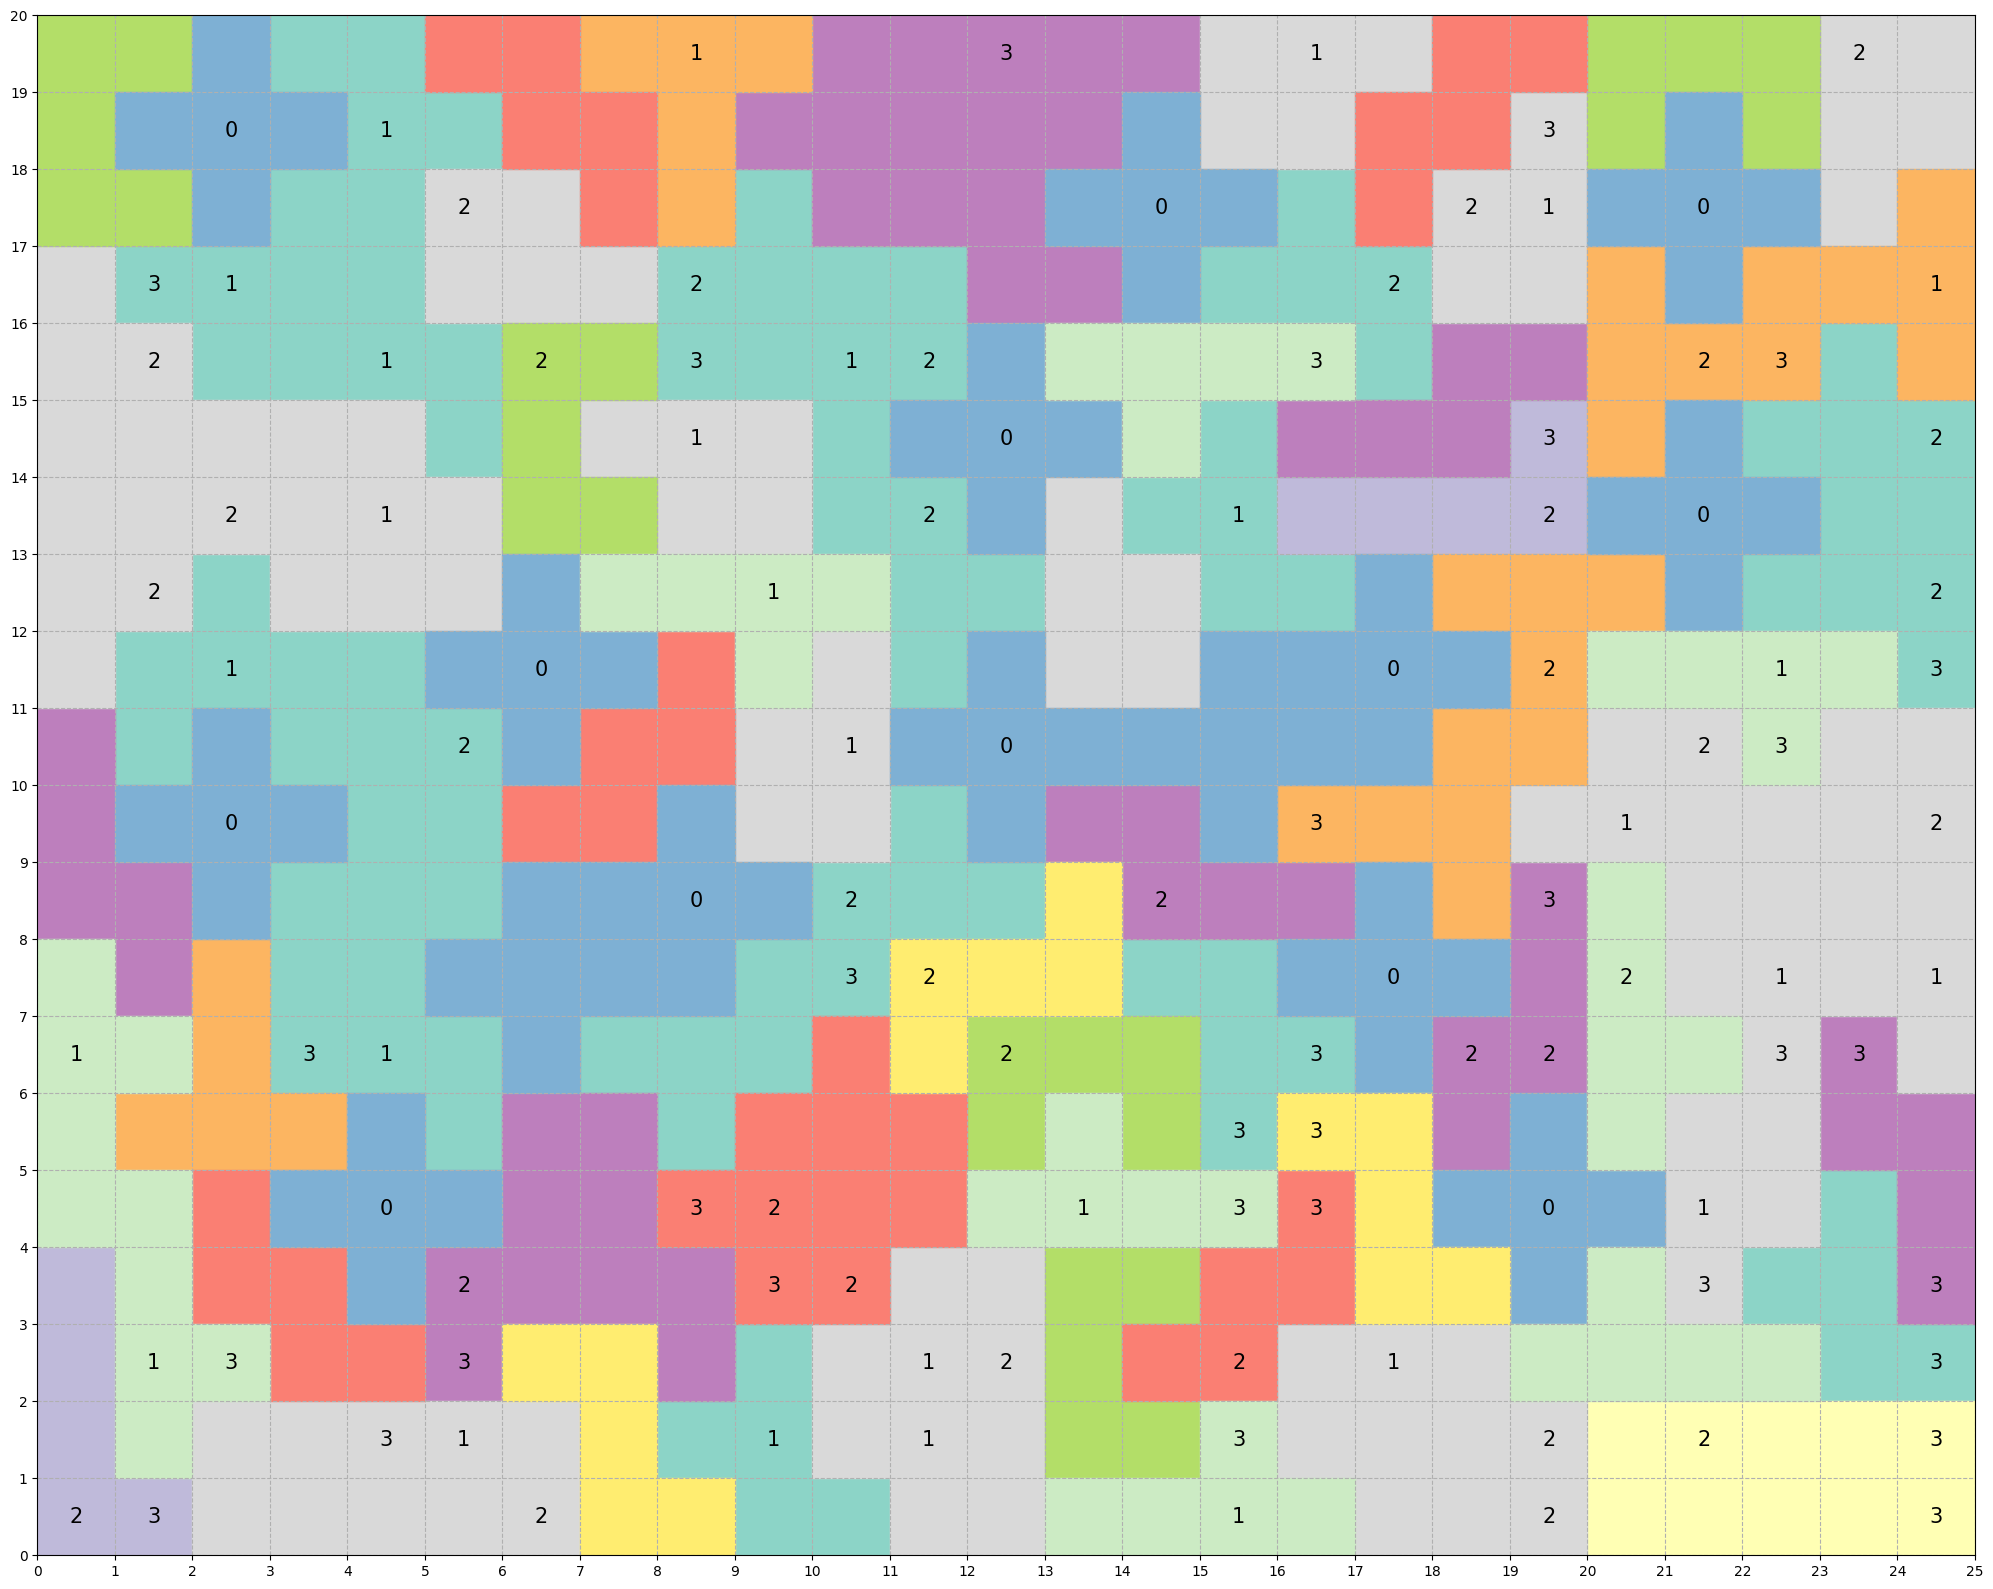

In [68]:
class VarArraySolutionCollector(cp.CpSolverSolutionCallback):

    def __init__(self, variables):
        cp.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.solution_list = []
        self.solution_sum = 0

    def on_solution_callback(self):
        self.solution_sum += 1
        arx = dict()
        for (k, _) in self.__variables.items():
            if self.Value(self.__variables[k]) > 0:
                arx[k[0], k[1], k[2]] = 1
        self.solution_list.append(arx)
        # print(self.solution_sum)

class FiveCellsSolver:
    def __init__(self, X, Y, patterns, grid):
        self.X = X
        self.Y = Y
        self.model = cp.CpModel()
        self.solver = cp.CpSolver() 
        self.patterns = patterns
        self.x = {}
        self.y = {}
        
        assert len(grid) == X and len(grid[0]) == Y
        
        self.grid = grid
        self.avail_variables = {} # pattern that have specific cell which occupy cell i,j
        # self.pattern_choose = {} # 
        self.sol_collector = None # dict that record sols
        # for char_ in "FILNPTUVWXYZ":
        #     self.pattern_choose[char_] = []
        for i in range(X):
            for j in range(Y):
                if self.grid[i][j] != "x":
                    # Here, Diff from Pentomino Solver, cuz "0" is used to represent specific meaning in this puzzle,
                    # so "x" is used to represent "Non-Feasible cell"
                    self.avail_variables[i, j] = []
    
    def removeDuplication(self):
        """_summary_
        消除重复的拼接方式
        """
        pass
    
    def parse2Grid(self, pattern, pattern_border):
        fst, sec = np.where(pattern)
        rows, cols = pattern.shape[0], pattern.shape[1]
        reversed_pattern = np.flipud(pattern)
        reversed_border = np.flipud(pattern_border)
        # Extract coordinates where pattern is 1
        coords = np.argwhere(reversed_pattern == 1)
        # Create dictionary with weights
        border_weights = {tuple(coord): reversed_border[tuple(coord)] for coord in coords}
        return rows, cols, border_weights
    
    def check(self, i, j, border_weights):
        """_summary_
        Check if pattern (with border weights, of course) can be put to (i,j)
        检查是否可以把带有边的权重的形状放到i,j为左下角的位置里
        # Diff from Pentomino Solver
        """
        for pos, weight in border_weights.items():
            if self.grid[i + pos[0]][j + pos[1]] == "x":
                return False
            if self.grid[i + pos[0]][j + pos[1]] != ".":
                val_grid = int(self.grid[i + pos[0]][j + pos[1]])
                if val_grid != weight:
                    return False
        return True
            
    def solve(self):
        for idx, pattern in self.patterns.items():
            rows, cols, border_weights = self.parse2Grid(pattern[0], pattern[1])
            # if self.Y % 2 == 0 and self.X % 2 == 0 and idx.startswith("F"):
            #     self.divide = 1
            #     for i in range( (self.X + 1) // 2 - (rows - 1) // 2):
            #         for j in range((self.Y + 1) // 2 - (cols - 1) // 2):
            #             self.x[idx, i, j] = self.model.NewBoolVar(f"x[{idx}_{i}_{j}]")
            #             self.pattern_choose[idx[0]].append(self.x[idx, i, j])
            #             for (subxx, subyy) in fill_in_cells:
            #                 self.avail_variables[i + subxx, j + subyy].append(self.x[idx, i, j])
            # elif self.Y % 2 == 1 and self.X % 2 == 1 and idx.startswith("Y"):
            #     self.divide = 1
            #     for i in range( (self.X + 1) // 2 - (rows - 1) // 2):
            #         for j in range((self.Y + 1) // 2 - (cols - 1) // 2):
            #             self.x[idx, i, j] = self.model.NewBoolVar(f"x[{idx}_{i}_{j}]")
            #             self.pattern_choose[idx[0]].append(self.x[idx, i, j])
            #             for (subxx, subyy) in fill_in_cells:
            #                 self.avail_variables[i + subxx, j + subyy].append(self.x[idx, i, j])
            # else:
            for i in range(self.X - rows + 1):
                for j in range(self.Y - cols + 1):
                    if self.check(i, j, border_weights):
                        self.x[idx, i, j] = self.model.NewBoolVar(f"x[{idx}_{i}_{j}]")
                        # self.pattern_choose[idx[0]].append(self.x[idx, i, j])
                        # Since # of pattern used is not constrained, pattern_choose is useless :)
                        for (subxx, subyy) in border_weights.keys():
                            self.avail_variables[i + subxx, j + subyy].append(self.x[idx, i, j])
                        
            # self.model.Add(sum(current_candidates) == 1)
        for i in range(self.X):
            for j in range(self.Y):
                if self.grid[i][j] != "x": # Dont forget it's "x"
                    self.model.Add(sum(self.avail_variables[i, j]) == 1)
        # for key, value in self.pattern_choose.items():
        #     self.model.Add(sum(value) <= 1 )        
        solution_collector = VarArraySolutionCollector(self.x)
        print("Start Solving...(Please wait...)")
        self.solver.SearchForAllSolutions(self.model, solution_collector)
        self.sol_collector = solution_collector
        print(f"总的摆放数： {self.sol_collector.solution_sum} （没有消重）")
        print(self.solver.SolutionInfo())
        print(self.solver.ResponseStats())

    def visualize(self):
        random.seed(123)
        plt.figure(figsize = (self.Y,self.X))
        ax = plt.gca()
        x_major_locator = MultipleLocator(1)
        y_major_locator = MultipleLocator(1)
        ax.xaxis.set_major_locator(x_major_locator)
        # 把x/y轴的主刻度设置为1的倍数
        ax.yaxis.set_major_locator(y_major_locator)
        plt.xlim(0,self.Y)
        plt.ylim(0,self.X)
        plt.grid(linestyle = "--")

        # result_idx = random.randint(0, len(self.sol_collector.solution_list))
        result_idx = 0
        
        # for i in range(self.X):
        #     for j in range(self.Y):
        #         if self.grid[i][j] == "1":
        #             ax.add_patch(Rectangle((j, i), 1, 1, color = "#02040A"))

        for i in range(self.X):
            for j in range(self.Y):
                if self.grid[i][j] in "0123456789":
                    ax.text(j + 0.5, i + 0.5, self.grid[i][j], 
                            horizontalalignment = "center", 
                            verticalalignment = 'center',
                            fontsize = 15)
        
        if self.sol_collector.solution_sum > 0:
            sol_c =  self.sol_collector.solution_list[result_idx]
            for shape, pos in sol_c.items():
                minocolor = COLORS[shape[0][0]]
                rows, cols, border_weights = self.parse2Grid(self.patterns[shape[0]][0], self.patterns[shape[0]][1])
                for sub_cell in border_weights.keys():
                    ax.add_patch(Rectangle((sub_cell[1] + shape[2], sub_cell[0] + shape[1]), 1, 1, color = minocolor))
        plt.savefig(f"../assets/figures/FiveCells/result_{self.X}x{self.Y}_{result_idx}.png")

if __name__ == "__main__":
    res_all_patterns = gen_patterns()
    m, n, grid = readGrid("20x25_1")
    PentominoSolverTest = FiveCellsSolver(m, n, res_all_patterns, grid = grid)
    PentominoSolverTest.solve()
    PentominoSolverTest.visualize()
    
    
    



In [69]:
# PentominoSolverTest.model.ExportToFile("./help.txt")
sol_list = PentominoSolverTest.sol_collector.solution_list[0]
# print(sol_list)
for k, v in sol_list.items():
    print(k, v)

print(len(sol_list.keys()))

('F_2', 5, 7) 1
('F_2', 14, 9) 1
('F_2', 15, 1) 1
('F_4', 0, 8) 1
('F_4', 2, 22) 1
('F_4', 12, 14) 1
('F_5', 5, 3) 1
('F_5', 9, 3) 1
('F_5', 11, 22) 1
('F_5', 13, 22) 1
('F_5', 14, 3) 1
('F_5', 15, 15) 1
('F_6', 7, 3) 1
('F_6', 7, 10) 1
('F_6', 10, 1) 1
('F_6', 15, 8) 1
('F_8', 5, 14) 1
('F_8', 11, 10) 1
('F_8', 17, 3) 1
('I_1', 0, 20) 1
('I_1', 1, 20) 1
('L_1', 13, 16) 1
('L_7', 0, 0) 1
('N_1', 8, 13) 1
('N_2', 14, 16) 1
('N_2', 18, 11) 1
('N_3', 2, 5) 1
('N_3', 5, 18) 1
('N_4', 2, 7) 1
('N_4', 7, 0) 1
('N_5', 16, 10) 1
('N_6', 18, 9) 1
('N_8', 3, 23) 1
('P_1', 0, 2) 1
('P_1', 16, 5) 1
('P_2', 0, 17) 1
('P_2', 2, 10) 1
('P_2', 9, 19) 1
('P_2', 9, 22) 1
('P_3', 9, 9) 1
('P_3', 16, 18) 1
('P_4', 11, 13) 1
('P_4', 12, 4) 1
('P_4', 14, 0) 1
('P_5', 0, 4) 1
('P_5', 0, 10) 1
('P_5', 13, 7) 1
('P_6', 1, 16) 1
('P_6', 18, 15) 1
('P_7', 3, 21) 1
('P_7', 11, 0) 1
('P_7', 17, 23) 1
('P_8', 6, 21) 1
('P_8', 6, 23) 1
('P_8', 12, 2) 1
('T_1', 14, 20) 1
('T_2', 8, 16) 1
('T_2', 15, 22) 1
('T_3', 5, 

In [56]:
print(res_all_patterns)

{'F_1': [array([[1, 0, 0],
       [1, 1, 1],
       [0, 1, 0]]), array([[3, 0, 0],
       [2, 1, 3],
       [0, 3, 0]])], 'F_2': [array([[0, 0, 1],
       [1, 1, 1],
       [0, 1, 0]]), array([[0, 0, 3],
       [3, 1, 2],
       [0, 3, 0]])], 'F_3': [array([[0, 1, 0],
       [0, 1, 1],
       [1, 1, 0]]), array([[0, 3, 0],
       [0, 1, 3],
       [3, 2, 0]])], 'F_4': [array([[0, 1, 0],
       [1, 1, 0],
       [0, 1, 1]]), array([[0, 3, 0],
       [3, 1, 0],
       [0, 2, 3]])], 'F_5': [array([[0, 1, 0],
       [1, 1, 1],
       [0, 0, 1]]), array([[0, 3, 0],
       [3, 1, 2],
       [0, 0, 3]])], 'F_6': [array([[0, 1, 0],
       [1, 1, 1],
       [1, 0, 0]]), array([[0, 3, 0],
       [2, 1, 3],
       [3, 0, 0]])], 'F_7': [array([[0, 1, 1],
       [1, 1, 0],
       [0, 1, 0]]), array([[0, 2, 3],
       [3, 1, 0],
       [0, 3, 0]])], 'F_8': [array([[1, 1, 0],
       [0, 1, 1],
       [0, 1, 0]]), array([[3, 2, 0],
       [0, 1, 3],
       [0, 3, 0]])], 'I_1': [array([[1, 1, 1, 1, 1]]

In [55]:
# print(PentominoSolverTest.avail_variables[0, 9])
x[L_2_0_5]
x[L_7_2_0]
x[N_1_5_0]
x[N_4_5_3]
x[N_5_3_1]
x[P_5_8_7]
x[P_6_0_0]
x[T_6_7_3]
x[V_1_0_2]
x[V_3_5_7]
x[W_1_2_5]
x[W_2_5_5]
x[W_3_1_1]
x[X_1_3_4]
x[X_4_7_5]
x[Y_4_0_8]
x[Z_2_6_0]
x[Z_3_4_7]
for k in PentominoSolverTest.avail_variables[9, 0]:
    print(k)

x[I_2_5_0]
x[I_4_5_0]
x[L_2_8_0]
x[P_4_7_0]
x[P_5_8_0]
x[T_1_7_0]
x[T_5_7_0]
x[T_6_7_0]
x[U_6_8_0]
x[V_2_7_0]
x[V_7_7_0]
x[W_2_7_0]
x[W_7_7_0]
x[Y_3_6_0]
x[Z_2_7_0]
x[Z_6_7_0]


In [15]:
import numpy as np

# Define the pattern and res arrays
pattern = np.array([
    [0, 1, 1],
    [1, 0, 0],
    [1,0,1]
])
res = np.array([
    [0, 3, 3],
    [0, 0, 0],
    [0,0,2]
])

# Adjust the function to account for row numbering from bottom to top
def create_weight_dict_bottom_to_top(pattern, res):
    # Reverse the row indices for pattern and res
    reversed_pattern = np.flipud(pattern)
    reversed_res = np.flipud(res)
    # Extract coordinates where pattern is 1
    coords = np.argwhere(reversed_pattern == 1)
    # Create dictionary with weights
    weights = {tuple(coord): reversed_res[tuple(coord)] for coord in coords}
    return weights

# Use the new function with the original arrays (since flipping is handled inside the function)
dicts_bottom_to_top = create_weight_dict_bottom_to_top(pattern, res)
print(dicts_bottom_to_top)


{(0, 0): 0, (0, 2): 2, (1, 0): 0, (2, 1): 3, (2, 2): 3}
